# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Imports

In [15]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#fix tensorflow, keras cuDNN error
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from keras.models import Sequential, Model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications.xception import Xception
from keras_hist_graph import plot_history
from sklearn.metrics import confusion_matrix
import itertools

from utils import load_images, plot_accuracy_and_loss, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (50,50))
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

In [8]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:08:00.0, compute capability: 7.5



# Parameters

In [3]:
train_dir = 'dogs_299/train/'
validation_dir = 'dogs_299/validation/'
test_dir = 'dogs_299/test/'

STD_SIZE = (299, 299)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [5]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']


# Model

In [6]:
conv_base = Xception(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [7]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [8]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 10 * 10 * 2048))
validation_features = np.reshape(validation_features, (-1, 10 * 10 * 2048))
test_features = np.reshape(test_features, (-1, 10 * 10 * 2048))

In [9]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Xception_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Xception_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 236 samples, validate on 50 samples
Epoch 1/1000
 - 1s - loss: 0.1029 - acc: 0.9407 - val_loss: 0.0045 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00449, saving model to tl_freeze_conv_base_Xception_2_breeds
Epoch 2/1000
 - 1s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00449 to 0.00194, saving model to tl_freeze_conv_base_Xception_2_breeds
Epoch 3/1000
 - 1s - loss: 9.4068e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00194 to 0.00123, saving model to tl_freeze_conv_base_Xception_2_breeds
Epoch 4/1000
 - 1s - loss: 5.2965e-04 - acc: 1.0000 - val_loss: 7.6188e-04 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00123 to 0.00076, saving model to tl_freeze_conv_base_Xception_2_breeds
Epoch 5/1000
 - 1s - loss: 2.5030e-04 - acc: 1.0000 - val_loss: 6.7185e-04 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.00076 to 0.00067, saving model 

## Results

In [10]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 0s 2ms/step


[1.2441734185044204e-06, 1.0]

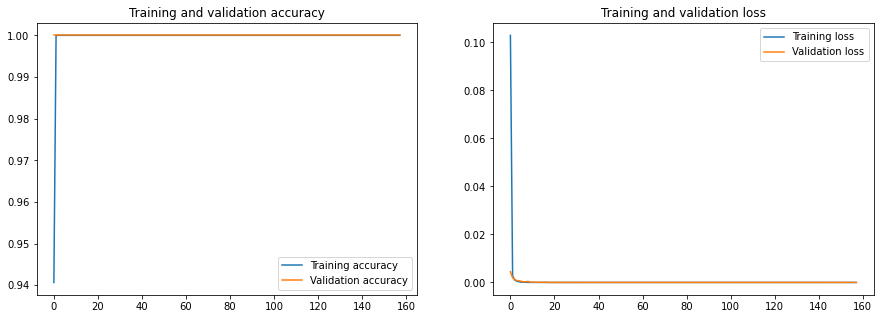

In [11]:
plot_accuracy_and_loss(history)

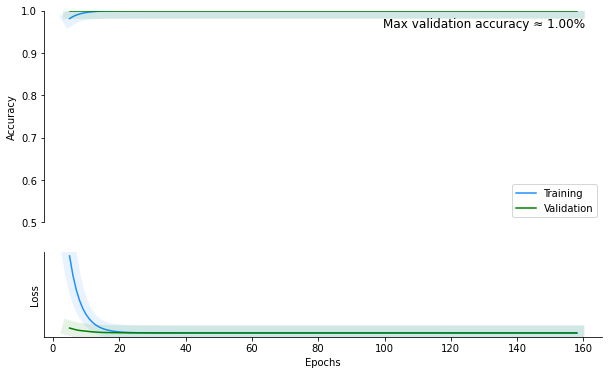

In [12]:
plot_history(history,xkcd=False)

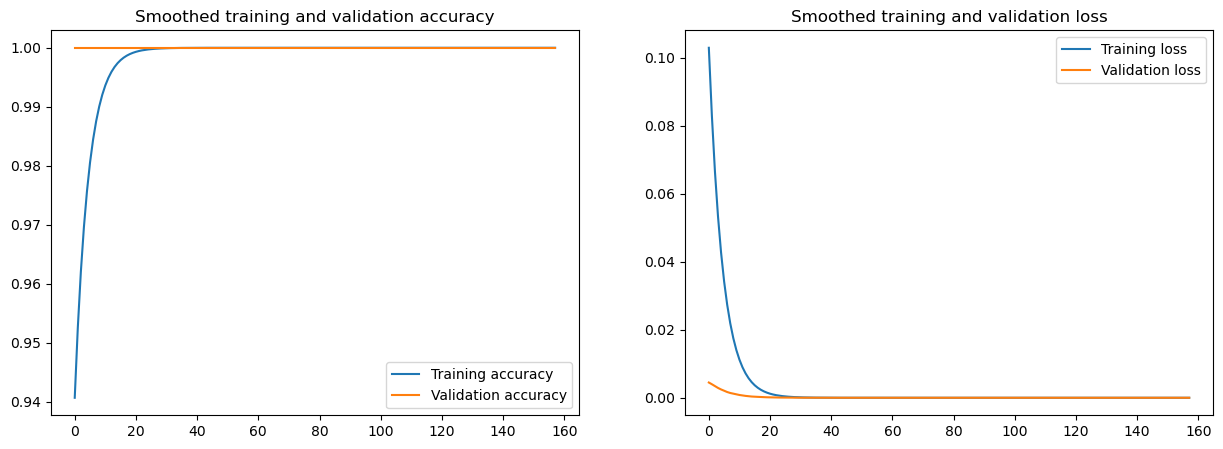

In [13]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [14]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


## Model

In [15]:
conv_base = Xception(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [16]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [17]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 10 * 10 * 2048))
validation_features = np.reshape(validation_features, (-1, 10 * 10 * 2048))
test_features = np.reshape(test_features, (-1, 10 * 10 * 2048))

In [18]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Xception_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Xception_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 412 samples, validate on 88 samples
Epoch 1/1000
 - 2s - loss: 0.0939 - acc: 0.9709 - val_loss: 0.0070 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00698, saving model to tl_freeze_conv_base_Xception_3_breeds
Epoch 2/1000
 - 2s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00698 to 0.00259, saving model to tl_freeze_conv_base_Xception_3_breeds
Epoch 3/1000
 - 2s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00259 to 0.00230, saving model to tl_freeze_conv_base_Xception_3_breeds
Epoch 4/1000
 - 2s - loss: 2.1204e-04 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00230 to 0.00148, saving model to tl_freeze_conv_base_Xception_3_breeds
Epoch 5/1000
 - 2s - loss: 6.1845e-05 - acc: 1.0000 - val_loss: 8.9882e-04 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.00148 to 0.00090, saving model to tl_fr

## Results

In [19]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 0s 3ms/step


[0.0009678113031465442, 1.0]

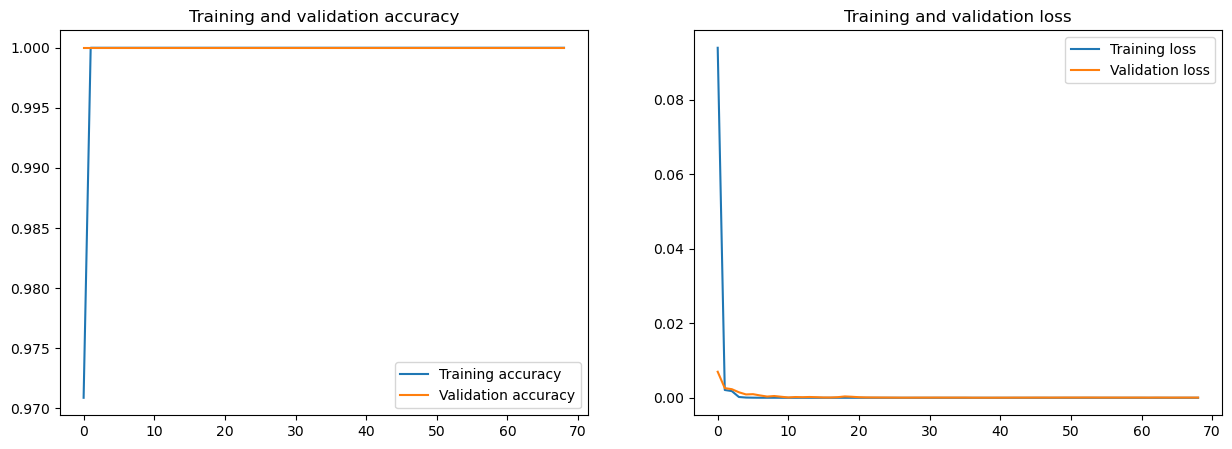

In [20]:
plot_accuracy_and_loss(history)

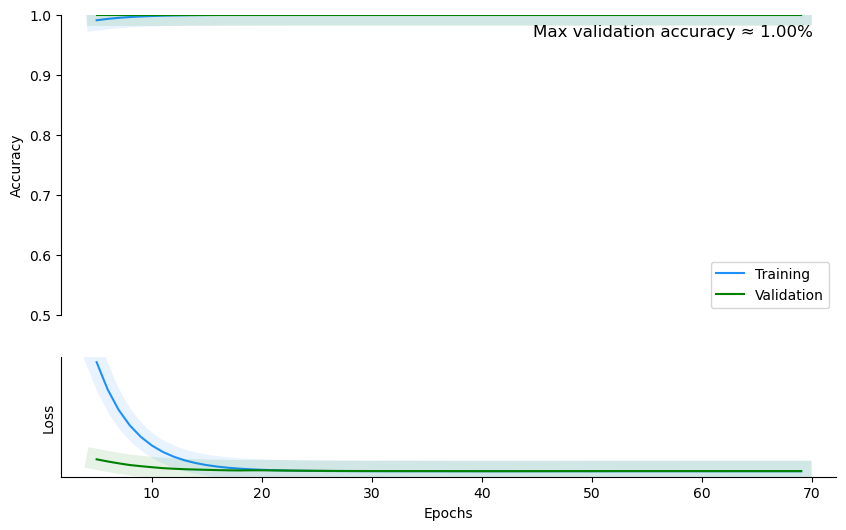

In [21]:
plot_history(history,xkcd=False)

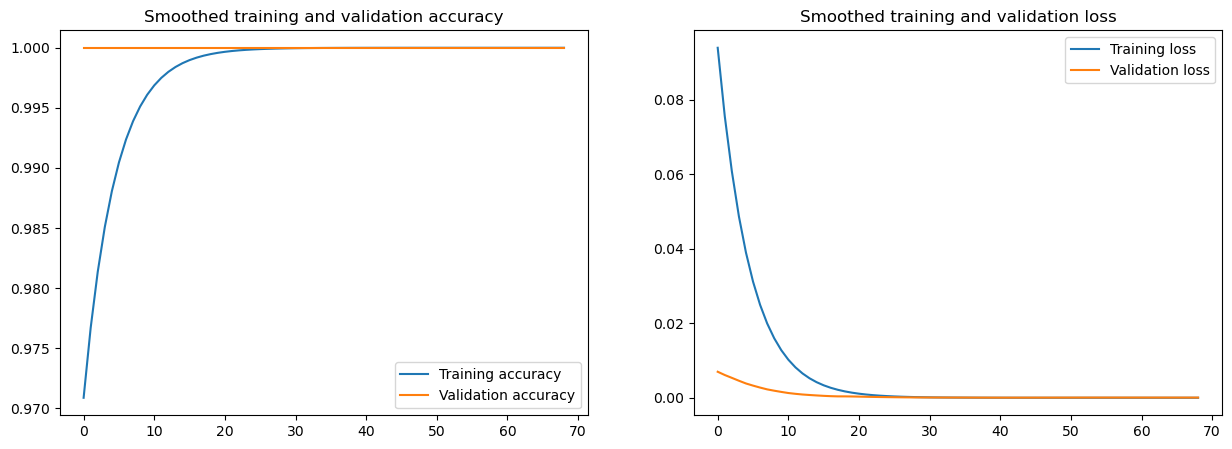

In [22]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

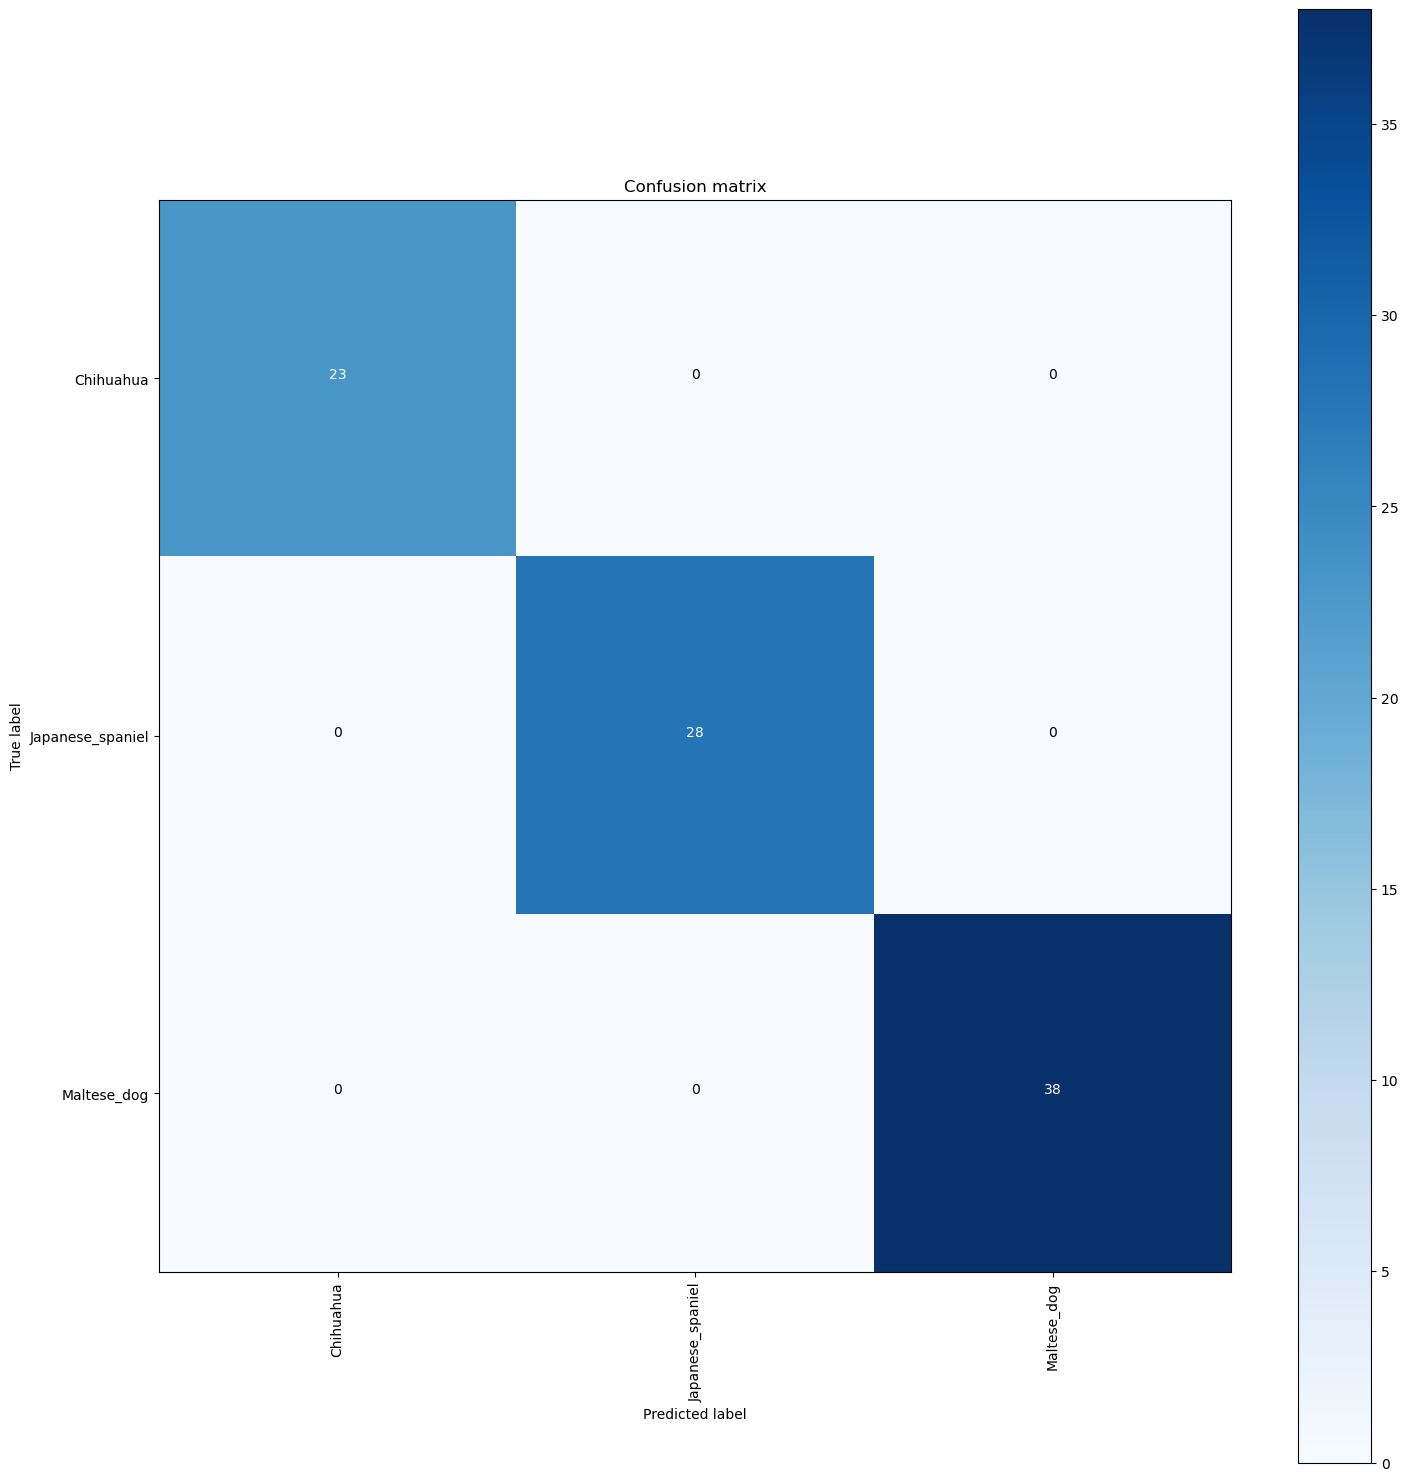

In [23]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [24]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']


## Model

In [25]:
conv_base = Xception(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [26]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [27]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 10 * 10 * 2048))
validation_features = np.reshape(validation_features, (-1, 10 * 10 * 2048))
test_features = np.reshape(test_features, (-1, 10 * 10 * 2048))

In [28]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Xception_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Xception_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 666 samples, validate on 143 samples
Epoch 1/1000
 - 3s - loss: 0.3019 - acc: 0.8979 - val_loss: 0.2106 - val_acc: 0.9441

Epoch 00001: val_loss improved from inf to 0.21061, saving model to tl_freeze_conv_base_Xception_5_breeds
Epoch 2/1000
 - 3s - loss: 0.0752 - acc: 0.9805 - val_loss: 0.1464 - val_acc: 0.9510

Epoch 00002: val_loss improved from 0.21061 to 0.14636, saving model to tl_freeze_conv_base_Xception_5_breeds
Epoch 3/1000
 - 3s - loss: 0.0336 - acc: 0.9910 - val_loss: 0.1729 - val_acc: 0.9371

Epoch 00003: val_loss did not improve from 0.14636
Epoch 4/1000
 - 3s - loss: 0.0232 - acc: 0.9970 - val_loss: 0.2073 - val_acc: 0.9510

Epoch 00004: val_loss did not improve from 0.14636
Epoch 5/1000
 - 3s - loss: 0.0148 - acc: 0.9955 - val_loss: 0.2163 - val_acc: 0.9510

Epoch 00005: val_loss did not improve from 0.14636
Epoch 6/1000
 - 3s - loss: 0.0044 - acc: 1.0000 - val_loss: 0.2225 - val_acc: 0.9510

Epoch 00006: val_loss did not improve from 0.14636
Epoch 7/1000
 - 3s

## Results

In [29]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 0s 2ms/step


[0.0916891208698426, 0.9650349617004395]

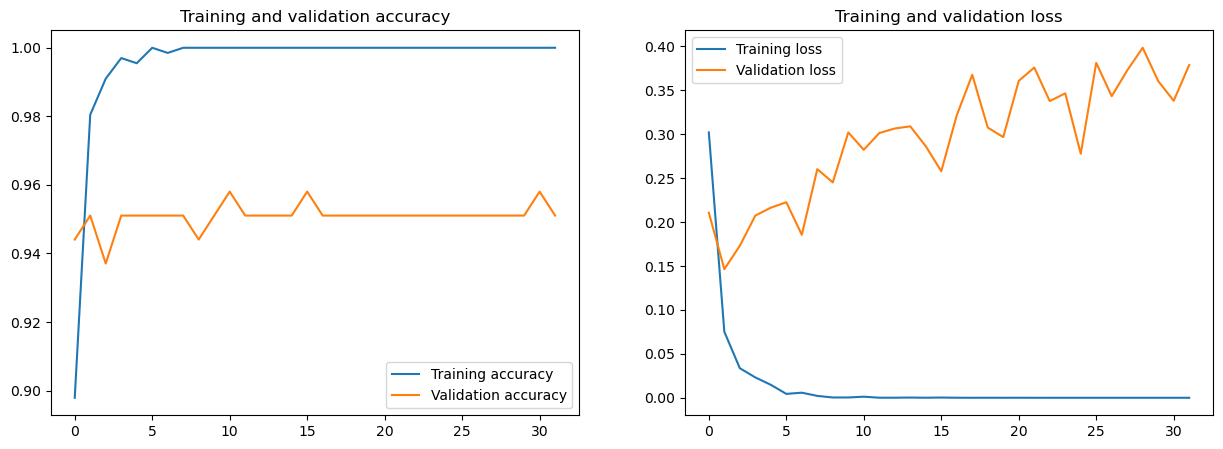

In [30]:
plot_accuracy_and_loss(history)

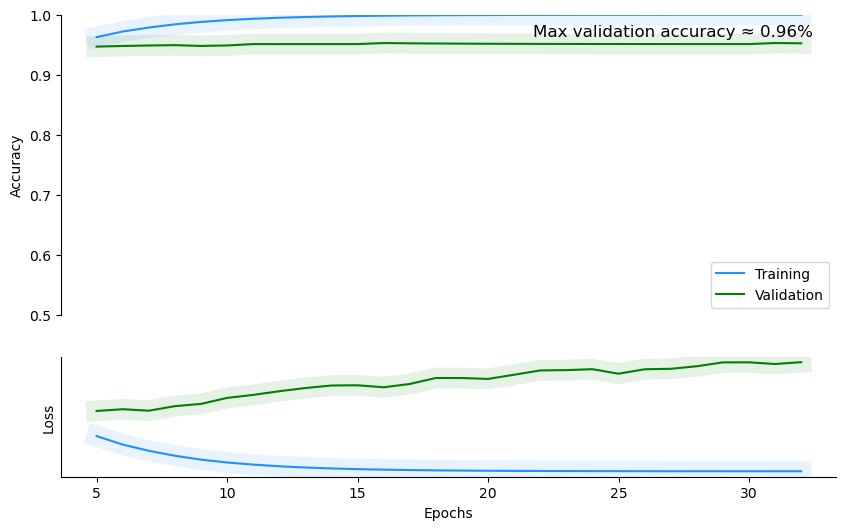

In [31]:
plot_history(history,xkcd=False)

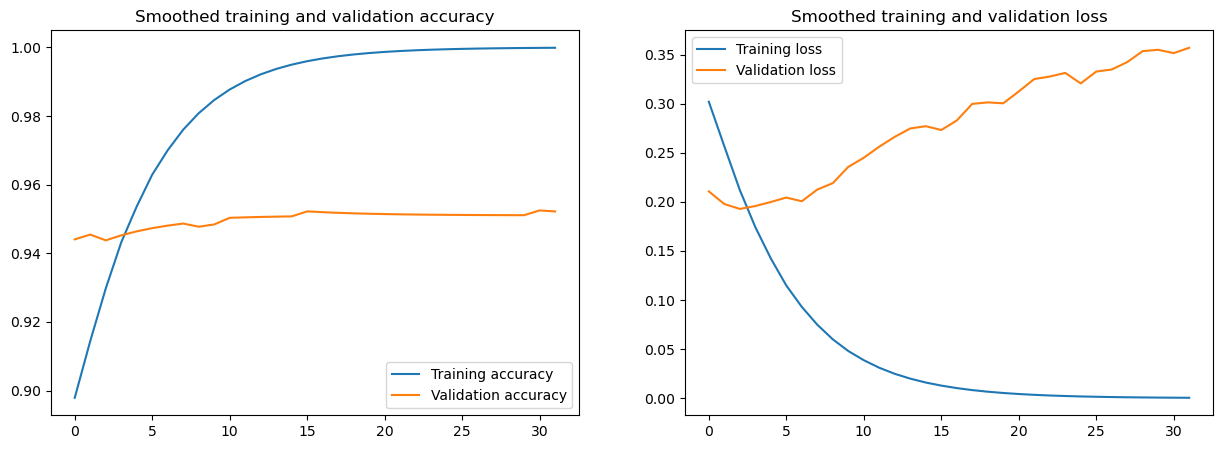

In [32]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

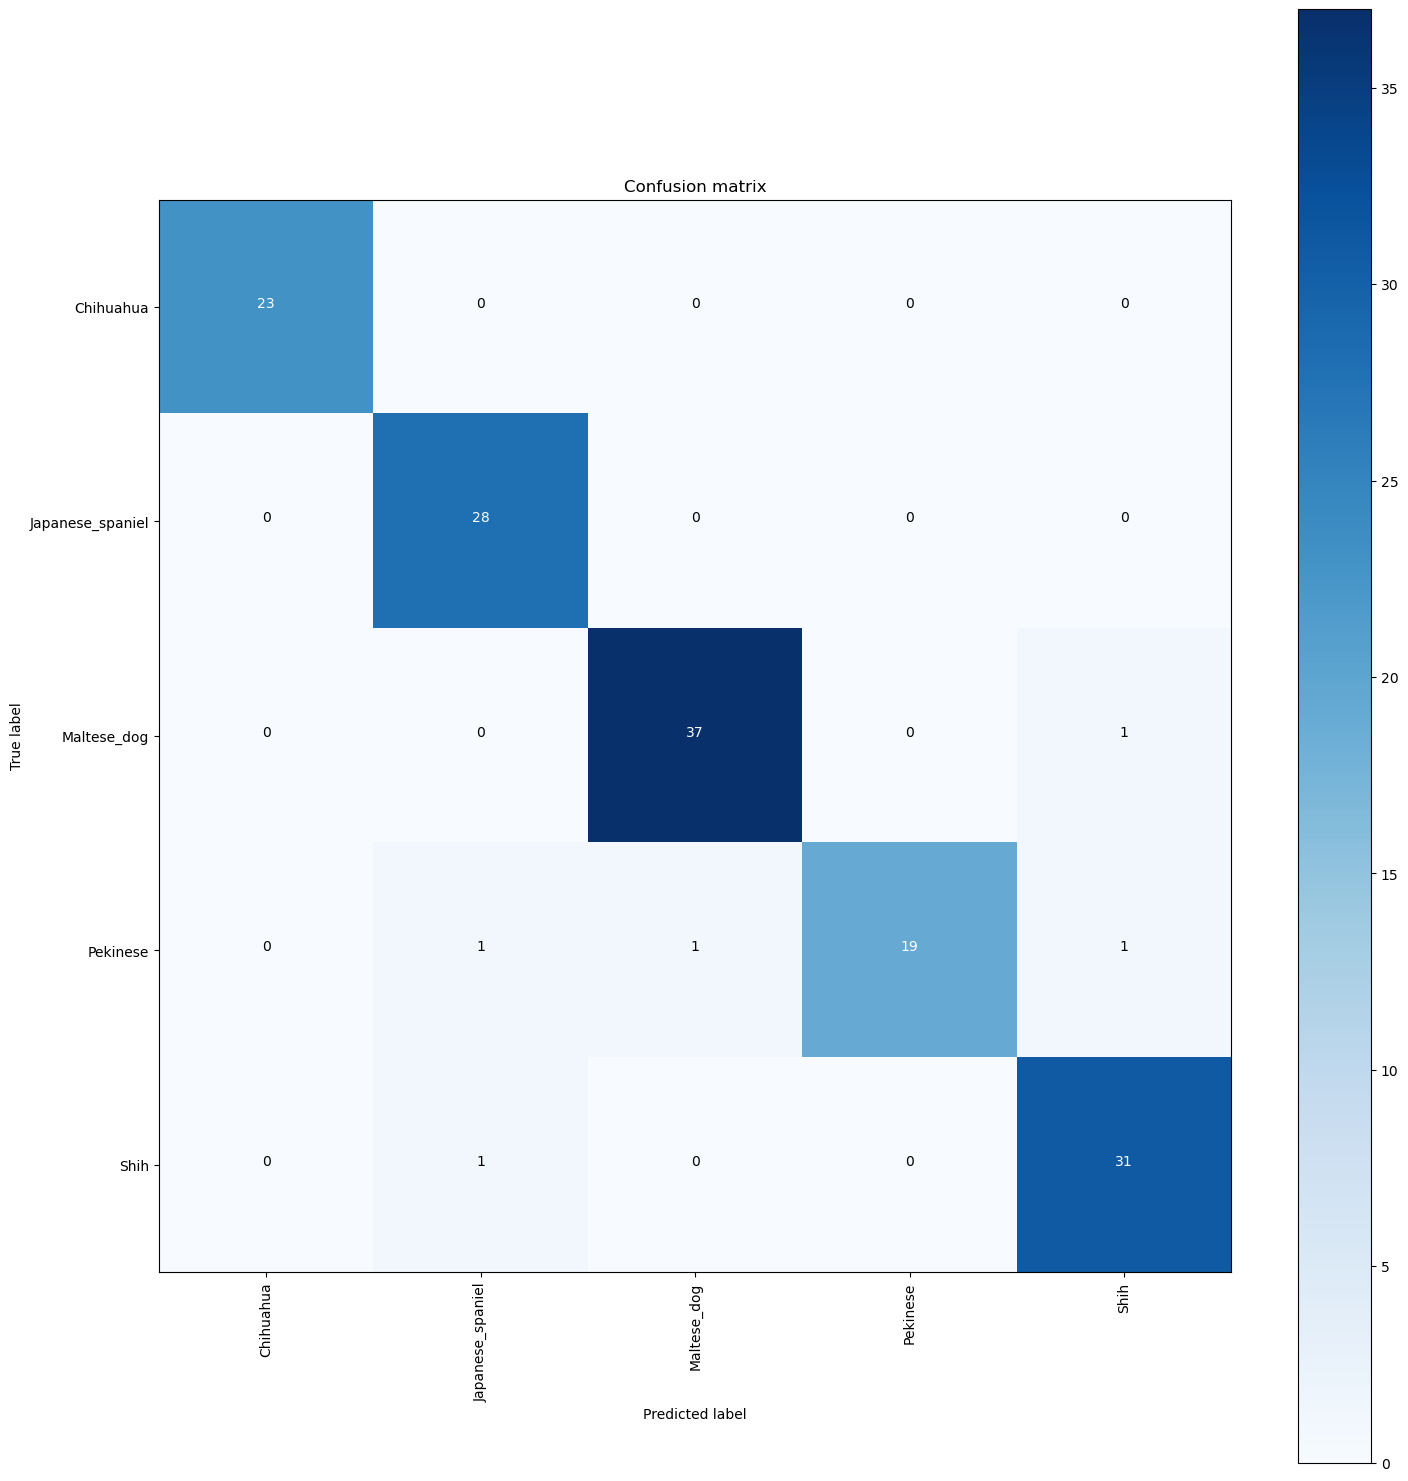

In [33]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [34]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [35]:
conv_base = Xception(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [36]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [37]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 10 * 10 * 2048))
validation_features = np.reshape(validation_features, (-1, 10 * 10 * 2048))
test_features = np.reshape(test_features, (-1, 10 * 10 * 2048))

In [38]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Xception_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Xception_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 7072 samples, validate on 1527 samples
Epoch 1/1000
 - 63s - loss: 0.9843 - acc: 0.7927 - val_loss: 0.3773 - val_acc: 0.9221

Epoch 00001: val_loss improved from inf to 0.37732, saving model to tl_freeze_conv_base_Xception_60_breeds
Epoch 2/1000
 - 53s - loss: 0.5077 - acc: 0.9033 - val_loss: 0.4199 - val_acc: 0.9240

Epoch 00002: val_loss did not improve from 0.37732
Epoch 3/1000
 - 53s - loss: 0.3649 - acc: 0.9314 - val_loss: 0.4377 - val_acc: 0.9267

Epoch 00003: val_loss did not improve from 0.37732
Epoch 4/1000
 - 60s - loss: 0.3115 - acc: 0.9433 - val_loss: 0.4941 - val_acc: 0.9332

Epoch 00004: val_loss did not improve from 0.37732
Epoch 5/1000
 - 54s - loss: 0.2521 - acc: 0.9552 - val_loss: 0.5917 - val_acc: 0.9286

Epoch 00005: val_loss did not improve from 0.37732
Epoch 6/1000
 - 53s - loss: 0.2024 - acc: 0.9641 - val_loss: 0.5734 - val_acc: 0.9312

Epoch 00006: val_loss did not improve from 0.37732
Epoch 7/1000
 - 55s - loss: 0.1903 - acc: 0.9672 - val_loss: 0.6561 

## Results

In [39]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 13s 9ms/step


[0.47894258247121735, 0.9047619104385376]

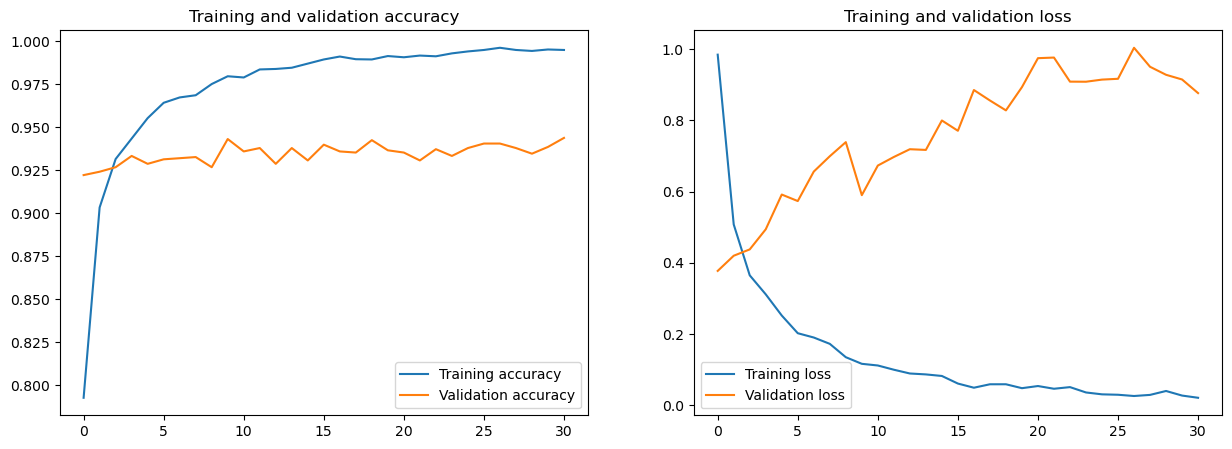

In [40]:
plot_accuracy_and_loss(history)

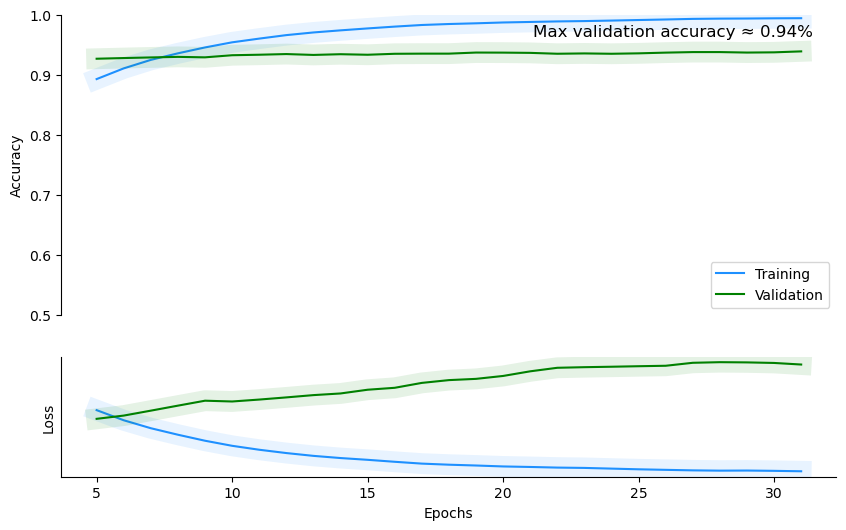

In [41]:
plot_history(history,xkcd=False)

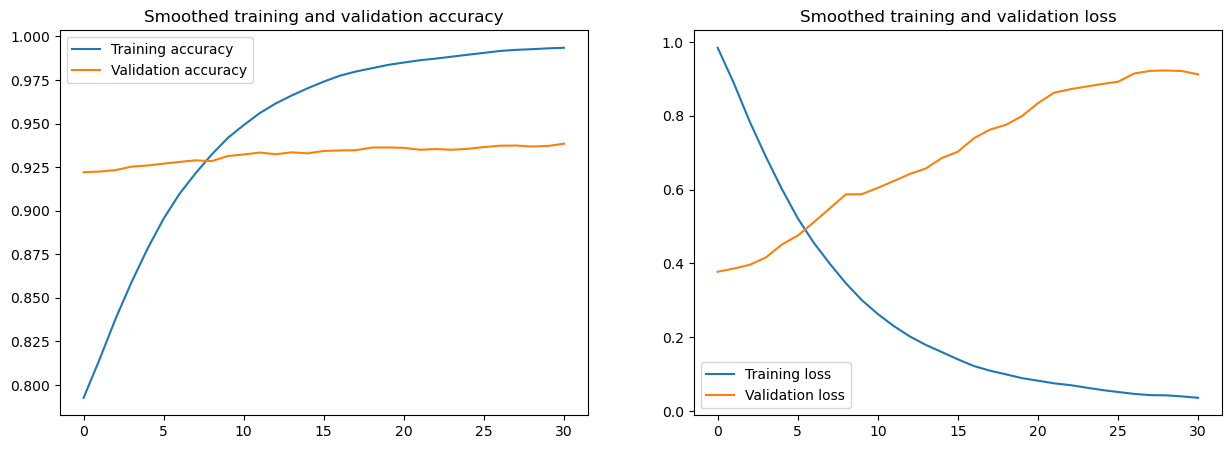

In [42]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

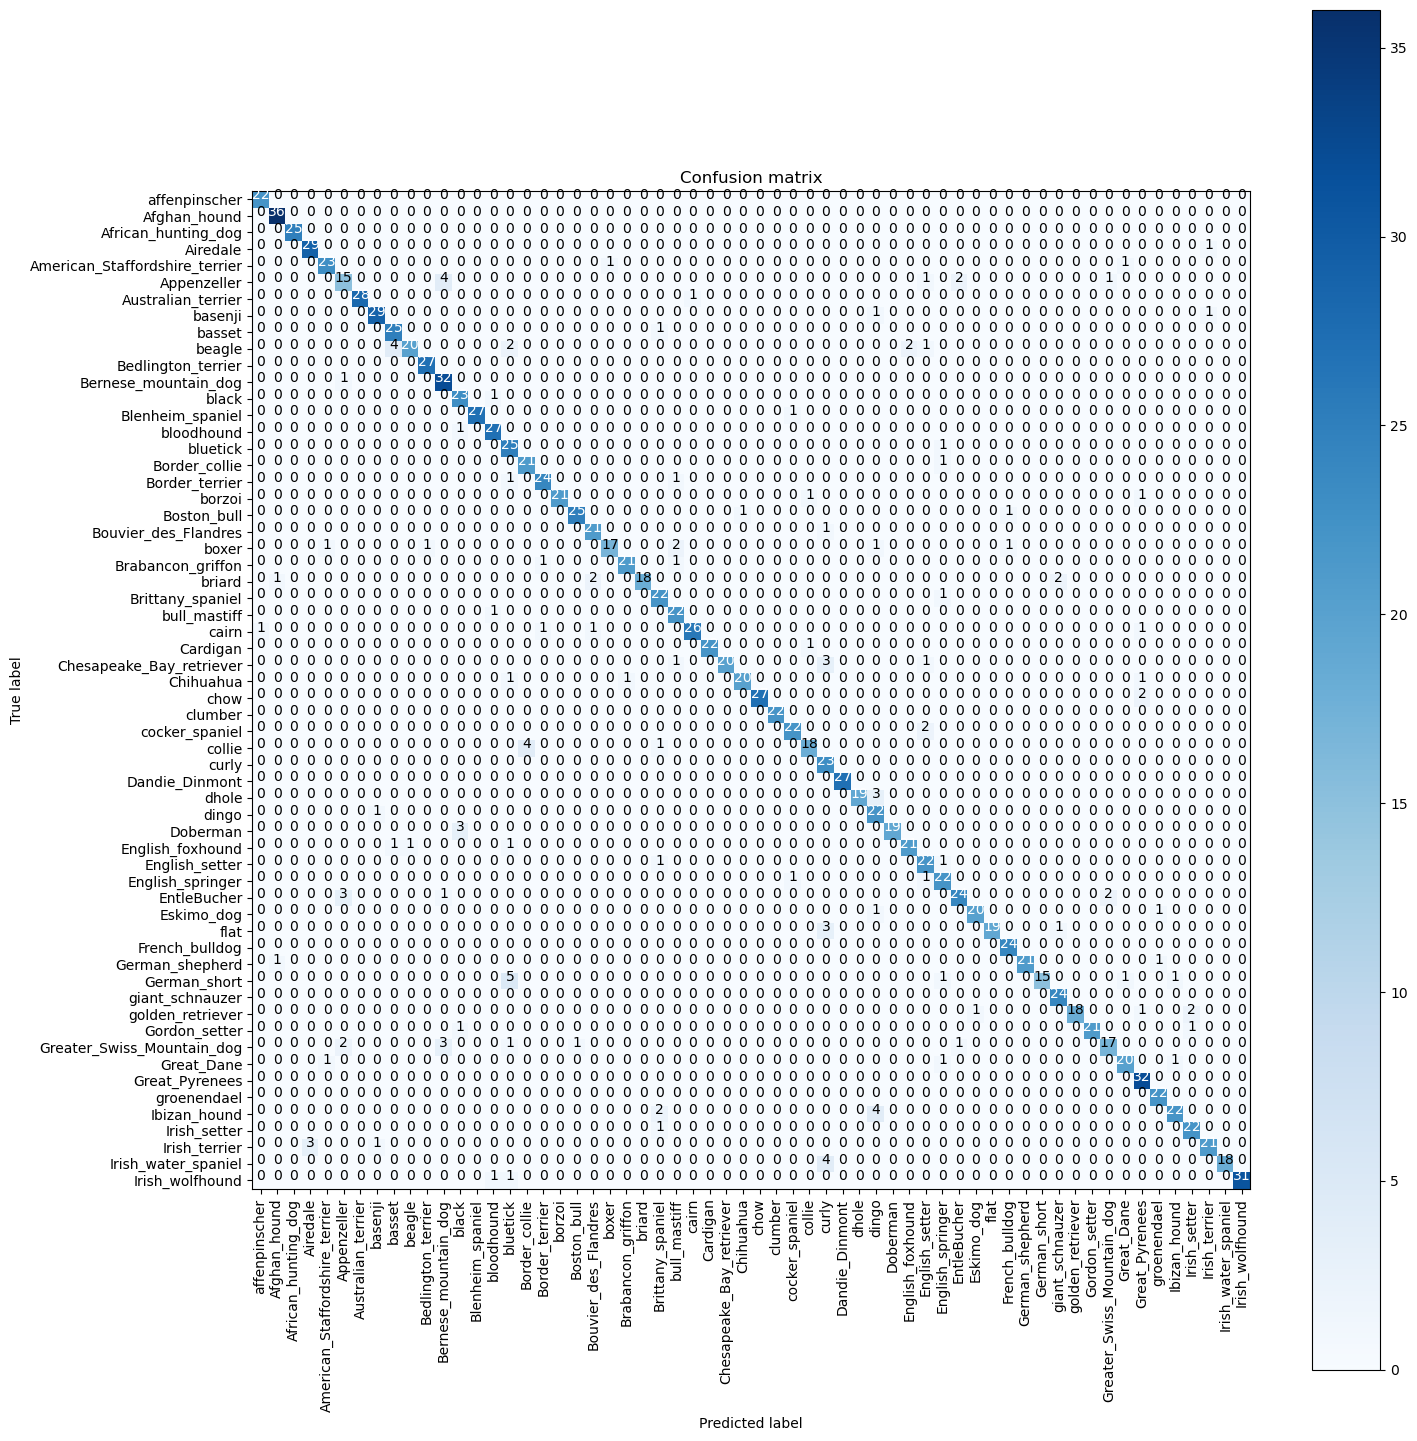

In [43]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 120 breeds

## Data preparation

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

# Model

In [5]:
conv_base = Xception(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [6]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

TF_ENABLE_GPU_GARBAGE_COLLECTION=False

In [8]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(10, 10, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 10 * 10 * 2048))
validation_features = np.reshape(validation_features, (-1, 10 * 10 * 2048))
test_features = np.reshape(test_features, (-1, 10 * 10 * 2048))

In [9]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Xception_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Xception_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 14397 samples, validate on 3099 samples
Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.40491, saving model to tl_freeze_conv_base_Xception_120_breeds
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tl_freeze_conv_base_Xception_120_breeds\assets
14397/14397 - 48s - loss: 1.3758 - acc: 0.7173 - val_loss: 0.4049 - val_acc: 0.8800
Epoch 2/1000

Epoch 00002: val_loss improved from 0.40491 to 0.37276, saving model to tl_freeze_conv_base_Xception_120_breeds
INFO:tensorflow:Assets written to: tl_freeze_conv_base_Xception_120_breeds\assets
14397/14397 - 42s - loss: 0.3654 - acc: 0.8982 - val_loss: 0.3728 - val_acc: 0.8922
Epoch 3/1000

Epoch 00003: val_loss improved from 0.37276 to 0.36578, saving model to tl_freeze_conv_base_Xception_120_breeds
INFO:tensorflow:Assets written to: tl_freeze_conv_base_Xception_120_breeds\assets
14397/14397 - 50s - loss: 0.2376 - acc: 0.9307 - val_loss: 0.3658 - val_acc: 0.889

## Results

In [10]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 1s 320us/sample - loss: 0.3700 - acc: 0.8891


[0.36996287743207046, 0.8891051]

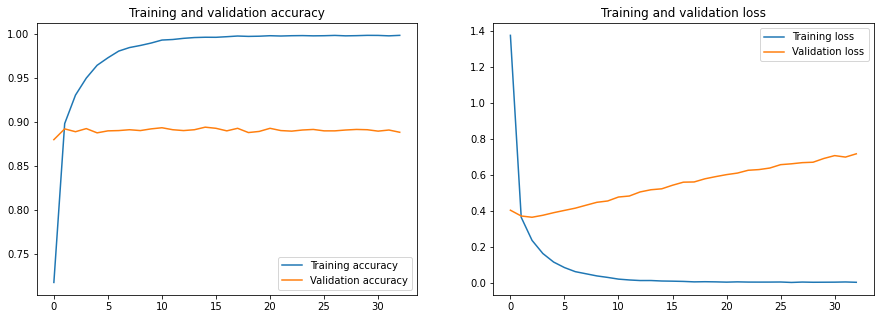

In [11]:
plot_accuracy_and_loss(history)

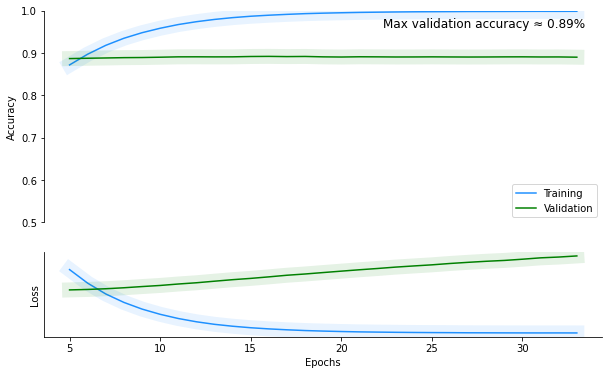

In [12]:
plot_history(history,xkcd=False)

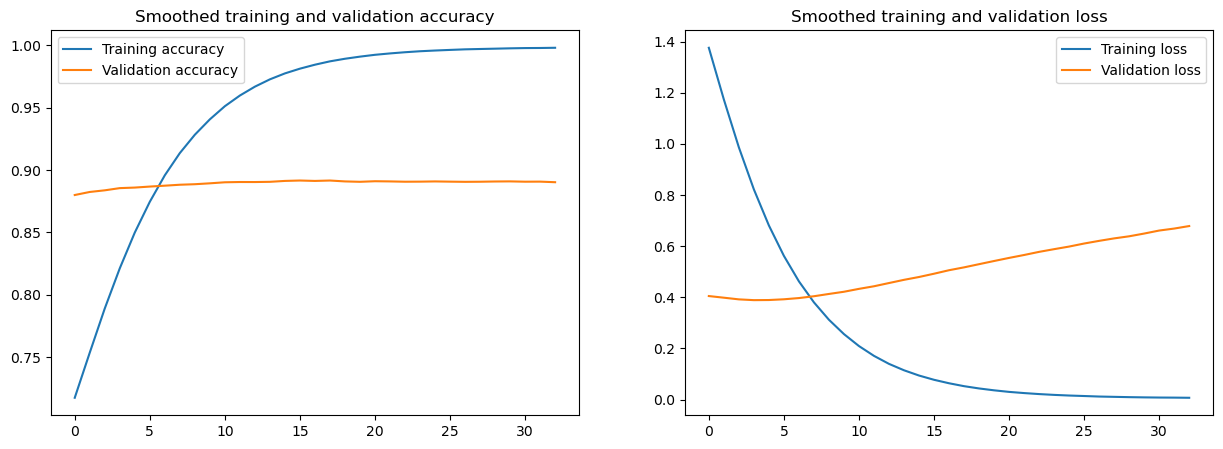

In [13]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

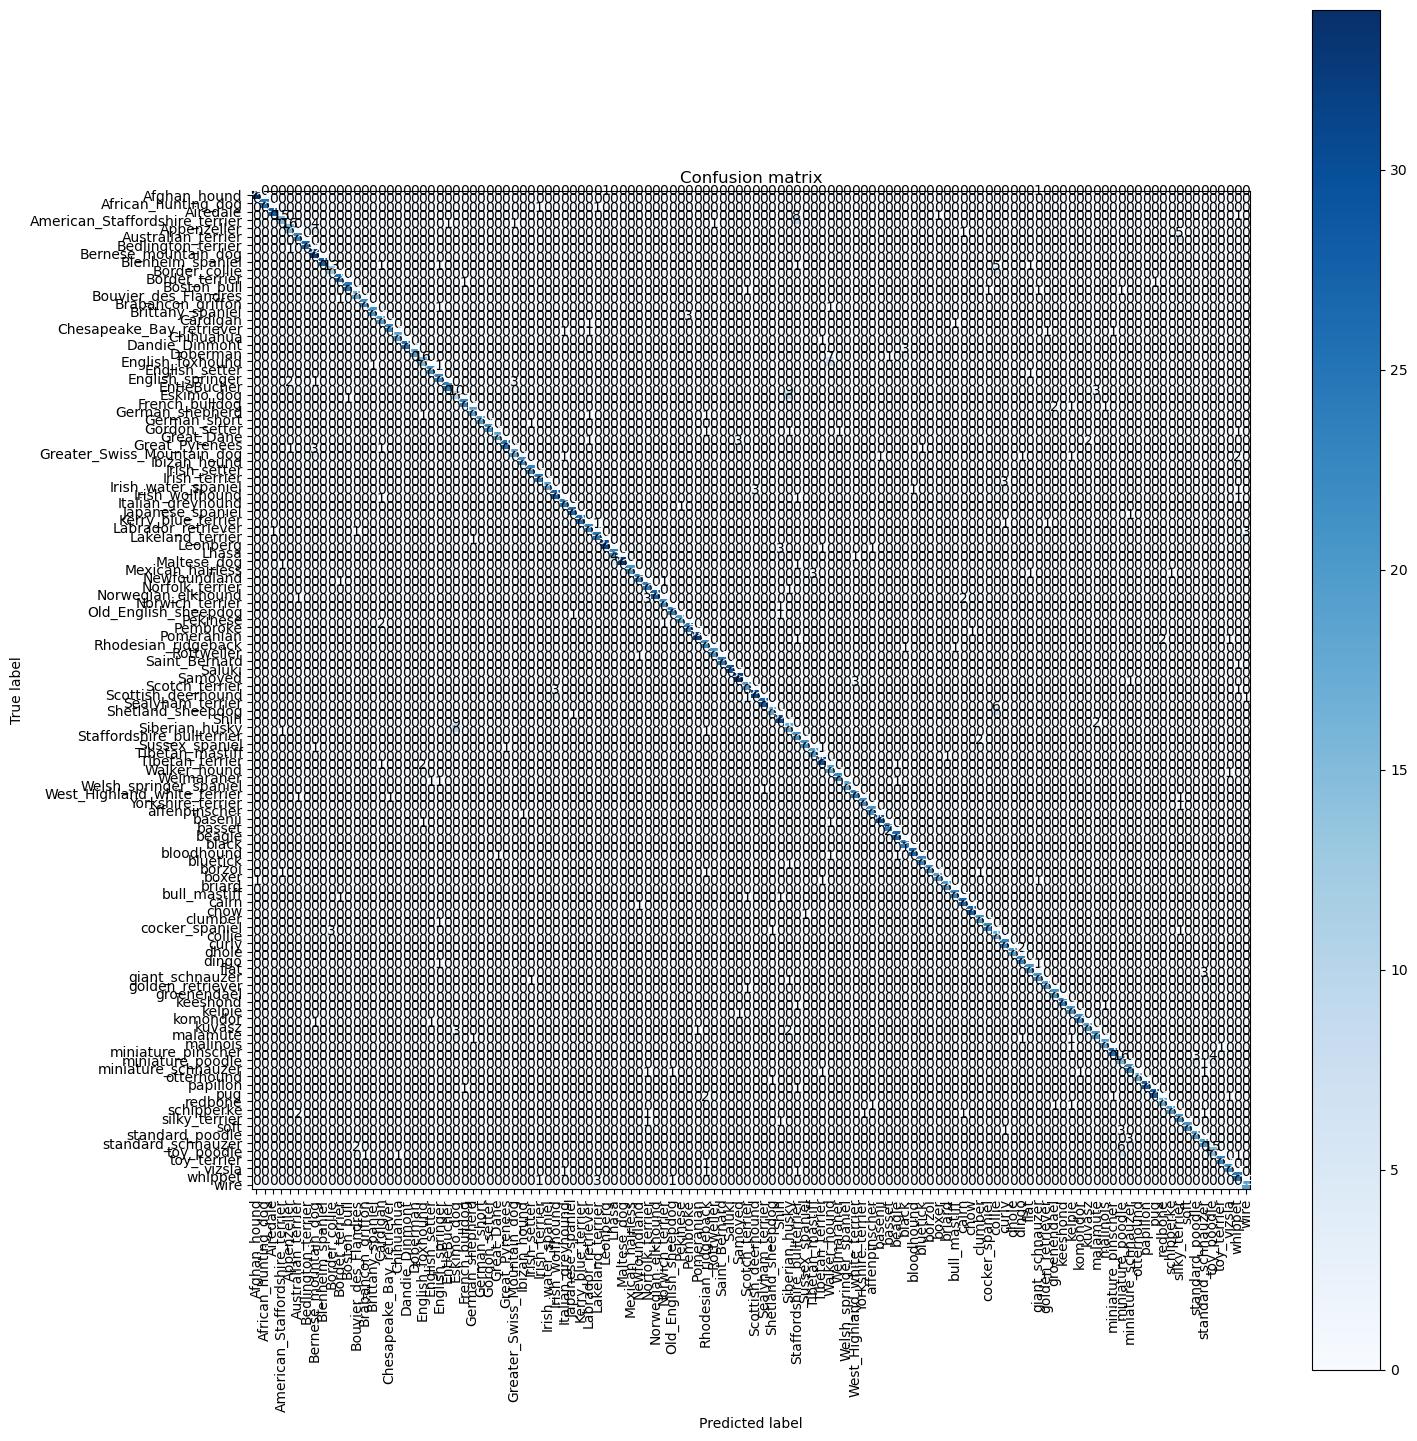

In [14]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()